In [1]:
import warnings
from helper import *
from pprint import pprint

In [2]:
# basic configuration
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 500)

In [3]:
# get the data files and their paths
file_dict, file_dir, master_dir = get_data_files()

In [4]:
# initialize the master dataframe to store all the data
master_df = pd.DataFrame()

In [5]:
# # get the file indexes
available_file_indexes = get_file_indexes(file_dict=file_dict)


In [6]:
# get file names for the given year(s)
file_dict_given_years = create_file_dict(file_dict=file_dict, years=[2022, 2023])

In [7]:
# find top 20 pipes for every file
for year, files in file_dict_given_years.items():
    access_index = 0
    for index in available_file_indexes[year]:
        master_df = find_common_pipes(file_index=access_index, file_year=year, 
                                      top_level_df=master_df, file_dict=file_dict, 
                                      master_dir=master_dir, threshold=50)
        access_index += 1

In [8]:
# create dataframe contains pipe production data for every week and write them to Excel files
exp_df, exp_df_th = create_transposed_and_unique_df(master_df=master_df, 
                                                    sheet_names=["General", "Experimental"], 
                                                    file_dir=file_dir)

In [9]:
# format the Excel files
format_general_sheet(file_dir=file_dir)
format_experimental_sheet(file_dir=file_dir)

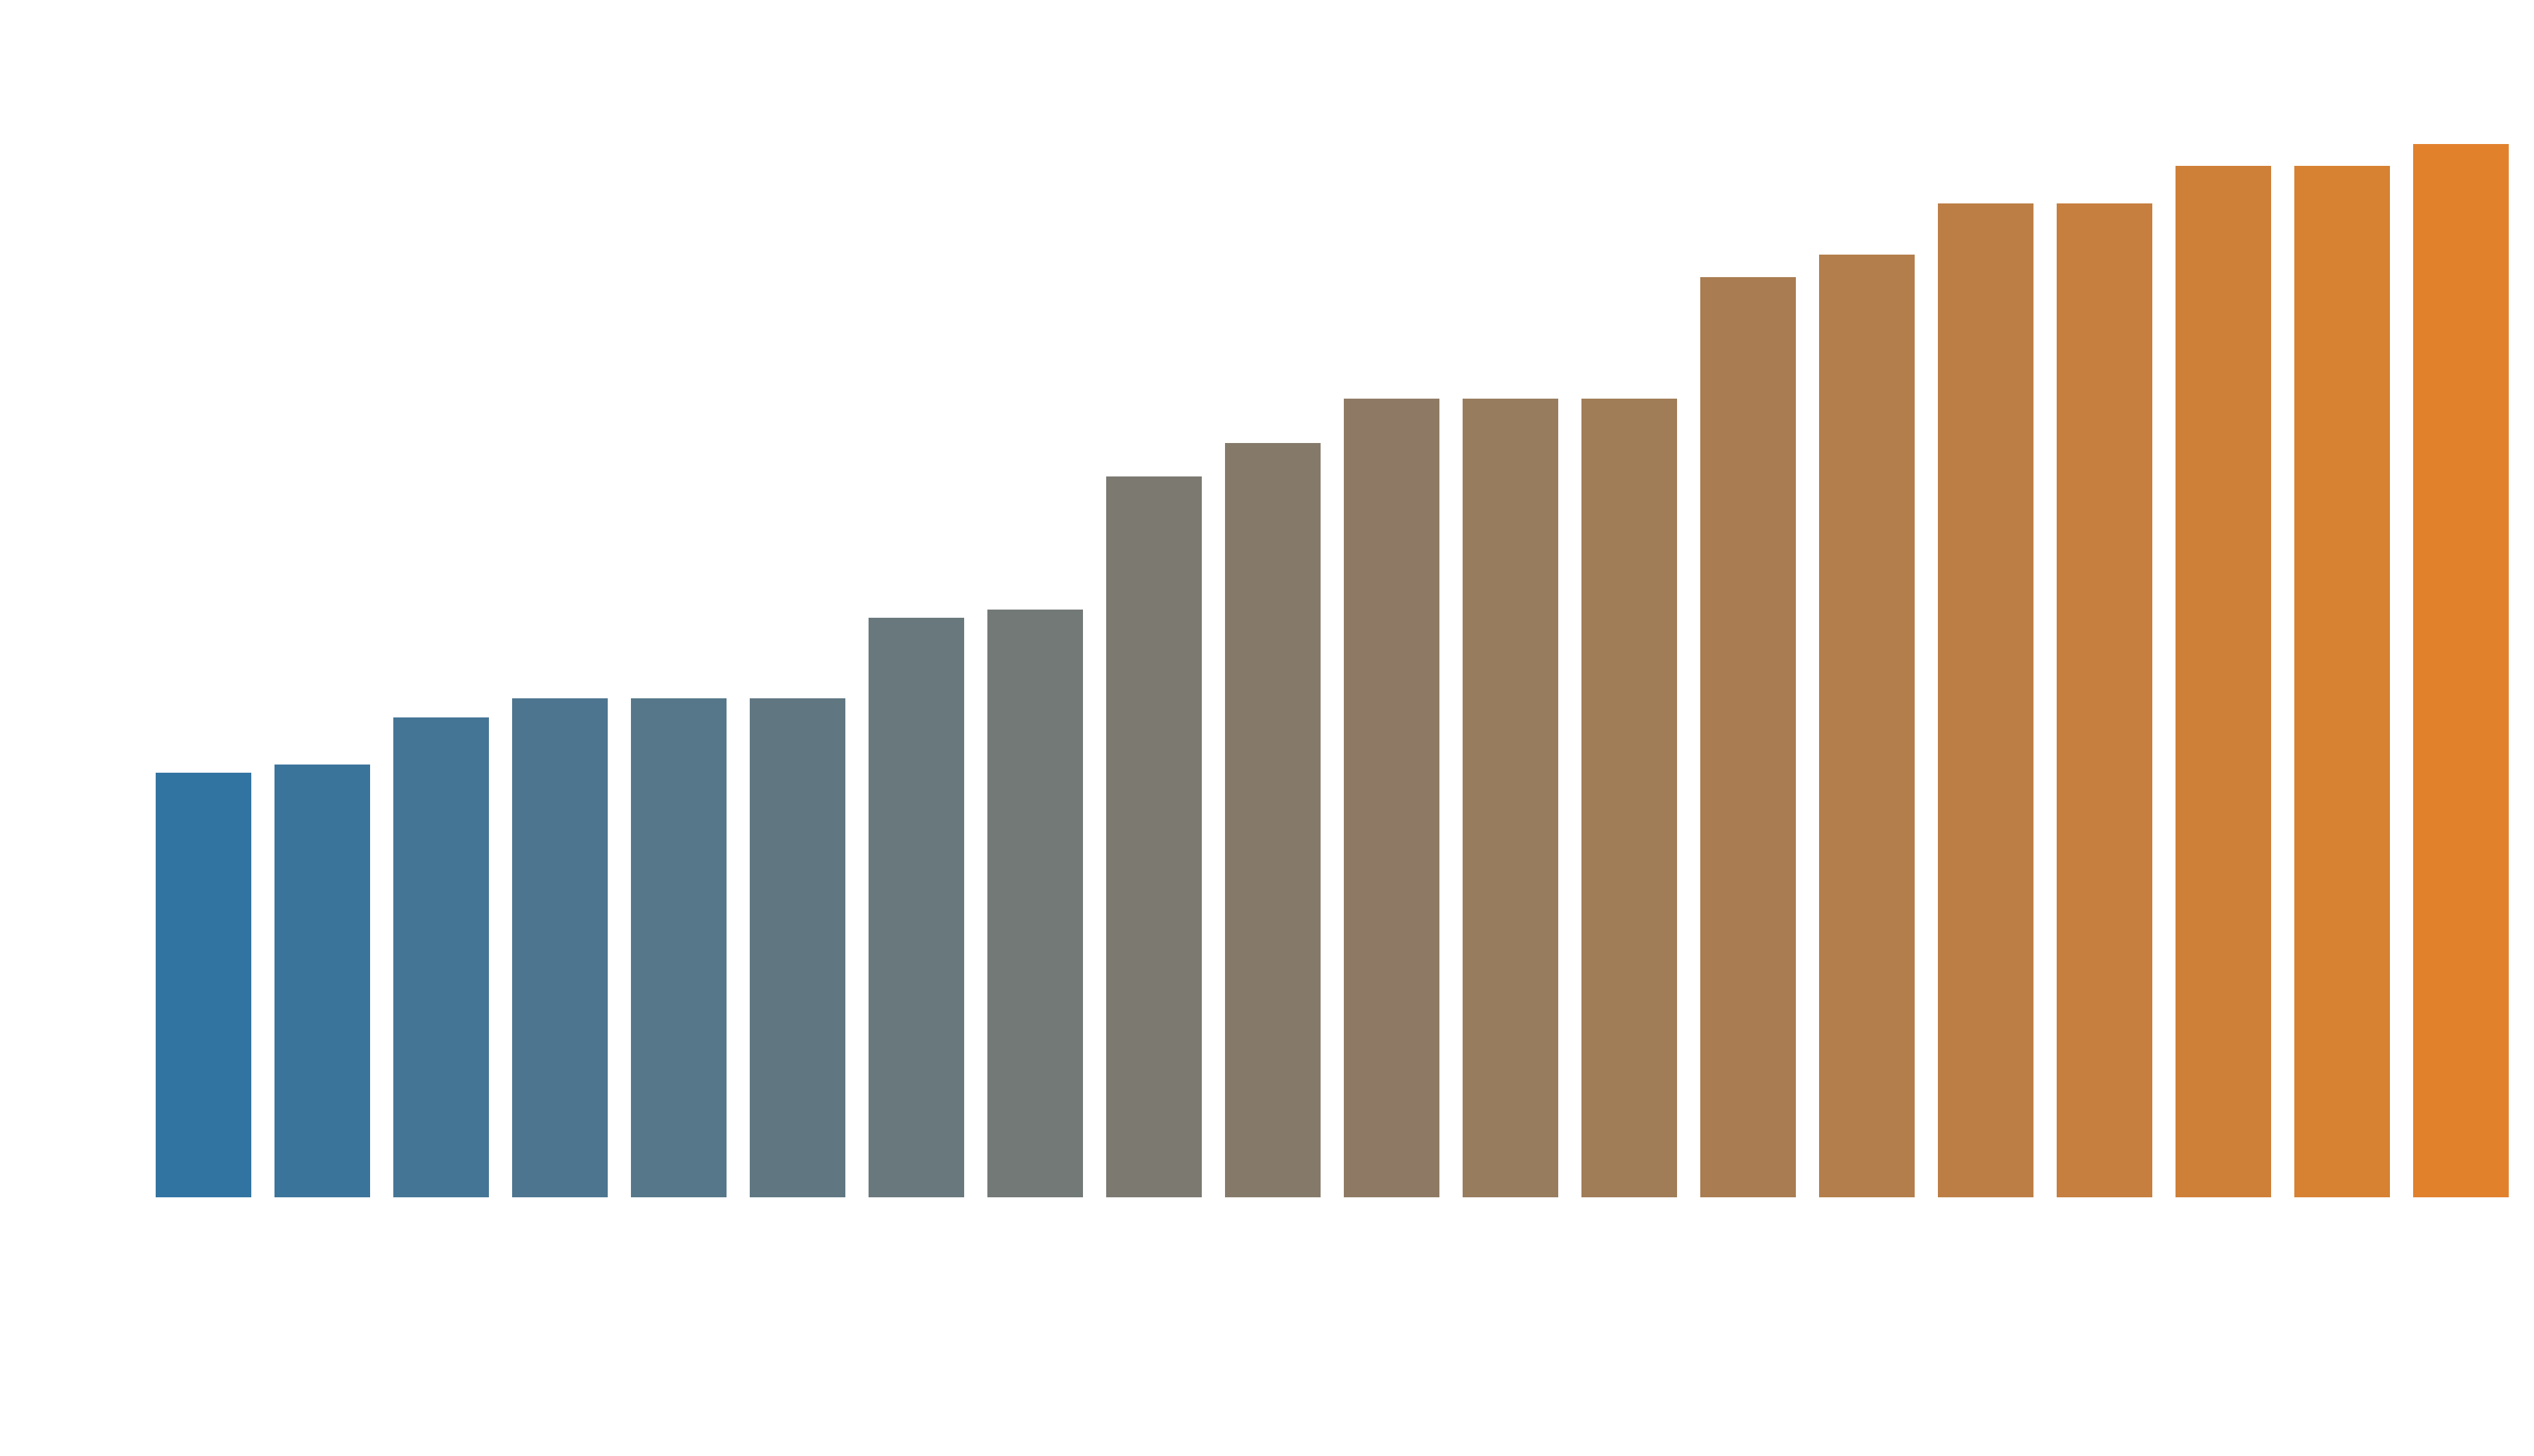

In [10]:
# plot the most popular 20 pipes for a specific week
create_bar_plot(df=exp_df_th,
                selected_year=2022,
                file_index="34",
                ascending=True,
                threshold=20)

In [11]:
# create a unique dataframe that contains all the data (2021-2023)
final_df = create_unique_df(df=exp_df)

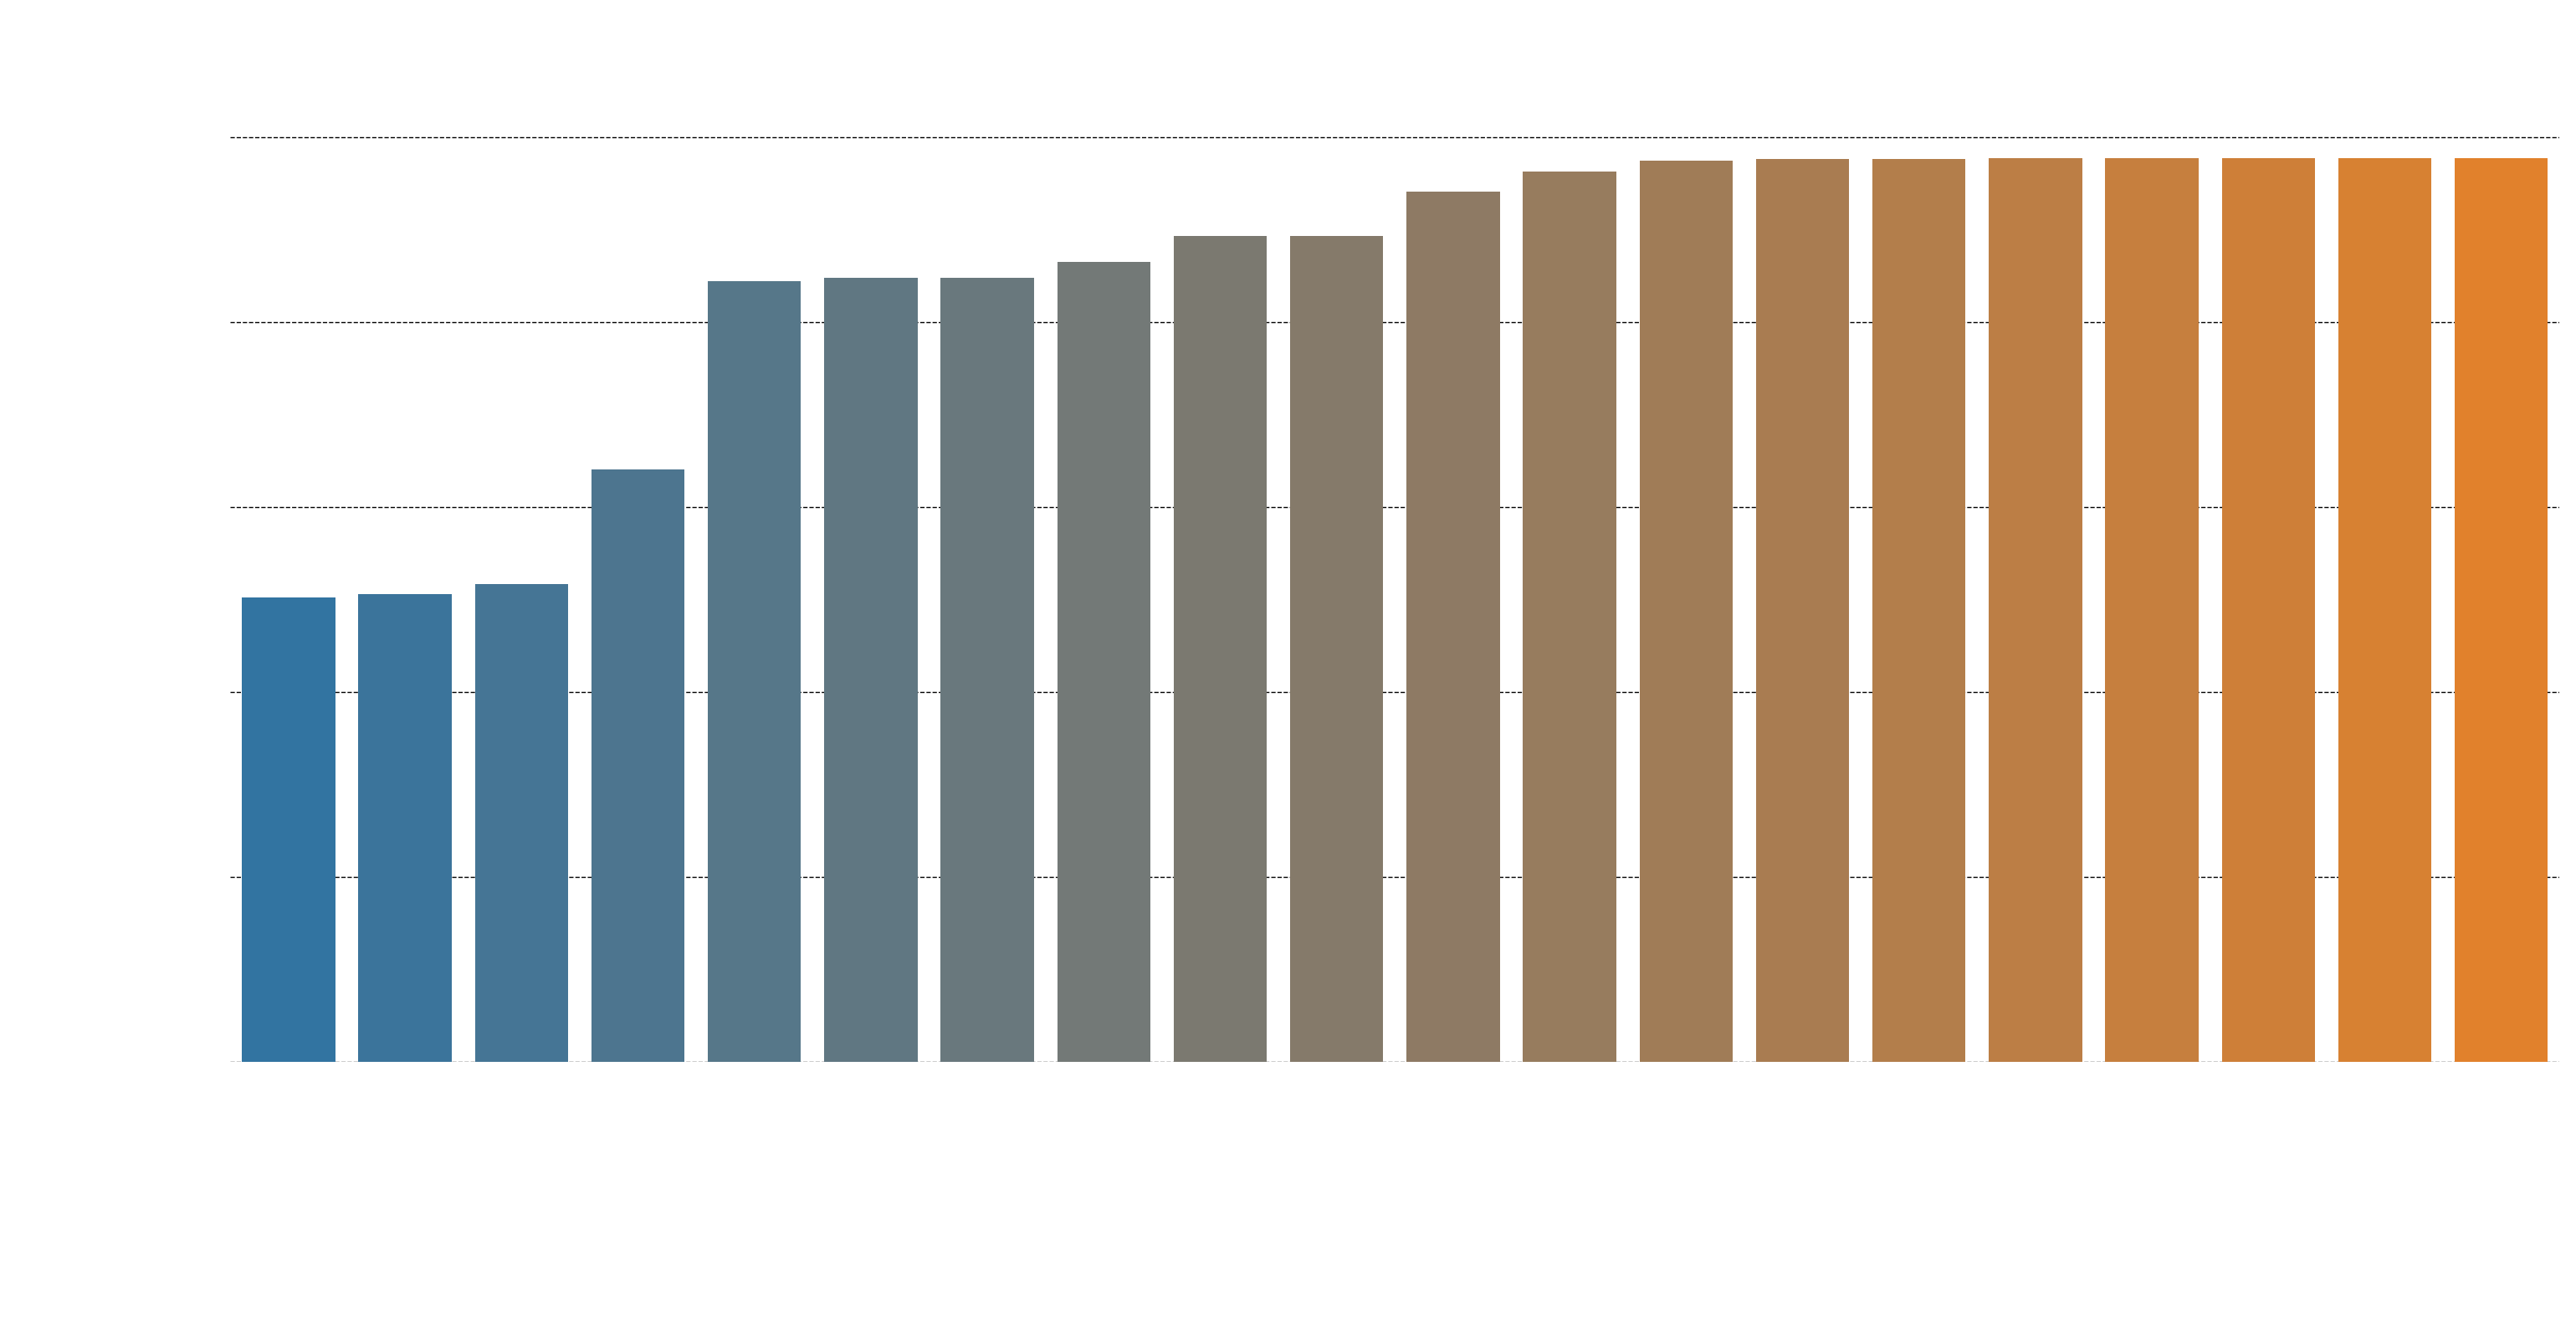

In [12]:
# plot the most popular 20 pipes for all the weeks (2021-2023)
unique_pipe_bar_plot(pipe_df=final_df,
                     total_quantity_limit=50000,
                     fig_size=(16, 7),
                     rotation='vertical',
                     ascending=True)

In [13]:
# get the occurrences per file
pipe_occurrences_df = get_occurrences_per_file(df=exp_df)

In [14]:
# get the files with a given threshold of occurrences
pipes_in_threshold_df = get_occurrences_with_threshold(df=pipe_occurrences_df, threshold=50)

In [15]:
# combine all the files satisfying the threshold for the popular pipes
all_in_one = combine_all_files_within_threshold(
    file_dict=file_dict_given_years, master_dir=master_dir, threshold_df=pipes_in_threshold_df)
all_in_one_T = convert_multi_to_single_df(df=all_in_one)

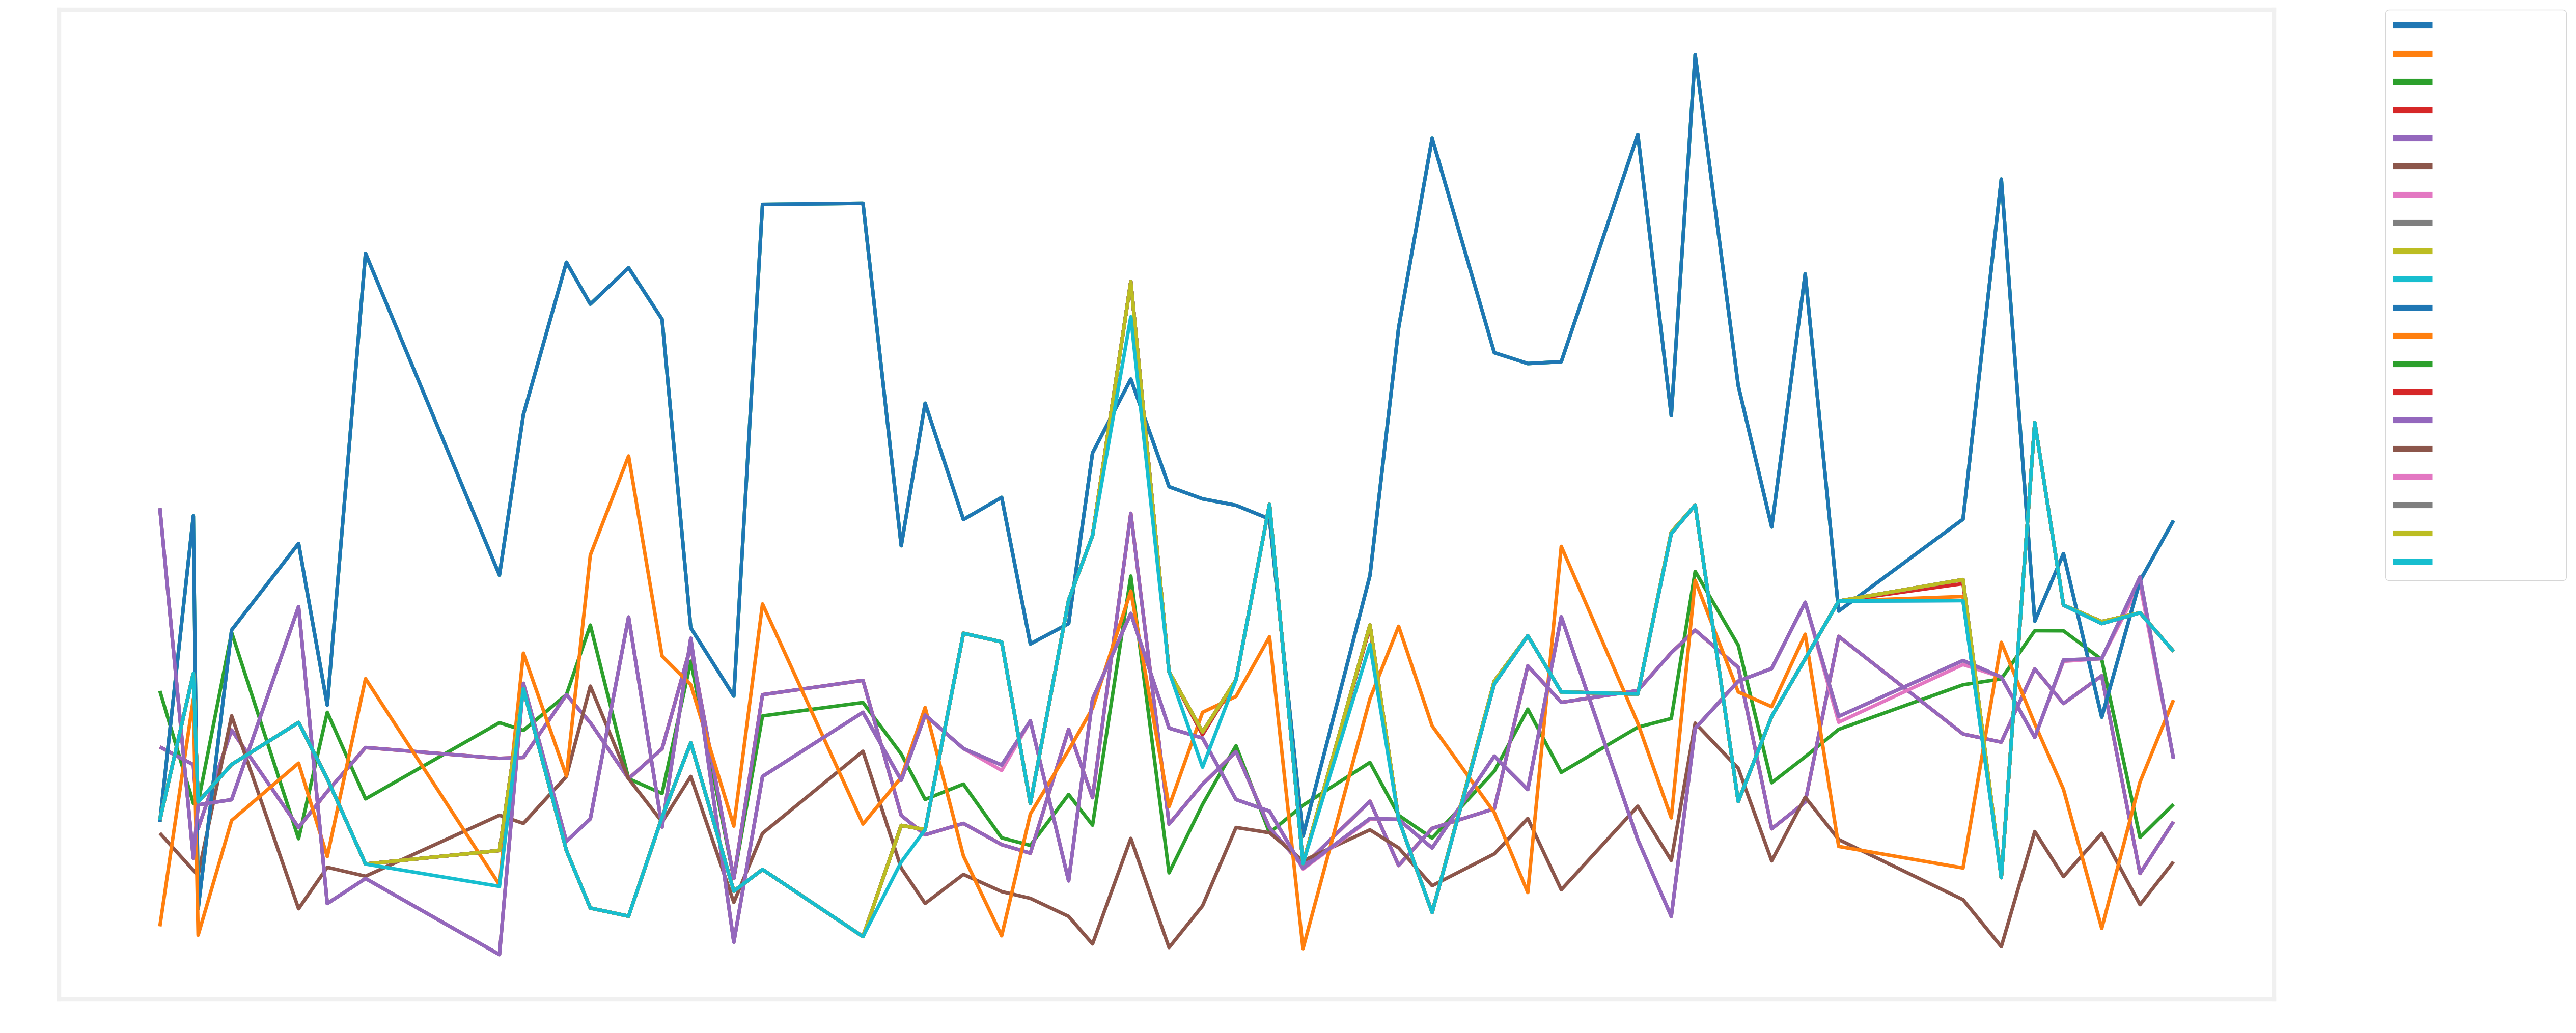

In [16]:
# plot the most popular 20 pipes throughout the given time period
fig, ax = plt.subplots(figsize=(25, 12))
sns.lineplot(data=all_in_one_T, palette="tab10", linewidth=2.5, ax=ax, dashes=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()